In [1]:
import pandas as pd
import numpy as np
import os

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [2]:
# Get relevant file paths
project_root = os.path.dirname(os.getcwd())
fall_18_data_path = project_root + '/Data/Fall_2018/'
fall_19_data_path = project_root + '/Data/Fall_2019/'

In [3]:
# Read in excel file with recipient gender hand labeled 
df_fall_18_messages = pd.read_excel(fall_18_data_path + 'FA18_messages_with_gender_recipients_hand_lableled.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(5039, 5)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w..."
3,25501571,WHITE,F,F,Upstairs from our lecture hall
4,25501571,WHITE,F,F,Sherman 207!!!


In [4]:
# Encode recipient gender char as int and create as new column in dataframe
# Remove rows where recipient's gender is unknown
male_val = 0
female_val = 1
neutral_val = 2

def encode(c):
    if (c == 'M'):
        return male_val
    elif (c == 'F'):
        return female_val
    elif (c == 'N'):
        return neutral_val

# Add column in dataframe for encoded gender
df_fall_18_messages['Recipient Gender Encoded'] = [encode(x) for x in df_fall_18_messages['Recipient Gender']]
# Drop nas (some genders were unknown in the dataset)
df_fall_18_messages = df_fall_18_messages[df_fall_18_messages['Recipient Gender Encoded'].notna()]
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(4872, 6)


,User ID,Sender Race,Sender Gender,Recipient Gender,Text,Recipient Gender Encoded
0,42683026,WHITE,F,F,Hey @Katie Poteet I know you said we should em...,1.0
1,25501571,WHITE,F,F,@Mary Cassell I would email Dr. K anyway with ...,1.0
2,42683026,WHITE,F,F,"Ok, thanks a lot. I have the email typed but w...",1.0
3,25501571,WHITE,F,F,Upstairs from our lecture hall,1.0
4,25501571,WHITE,F,F,Sherman 207!!!,1.0


In [5]:
# Get feature vector X and target label y 
fa_18_message_array = df_fall_18_messages['Text'].values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(fa_18_message_array)
y = df_fall_18_messages['Recipient Gender Encoded']

In [6]:
# Print y shape and number of instances of each label
print(y.shape)
print(y.value_counts())

(4872,)
2.0    2011
1.0    1517
0.0    1344
Name: Recipient Gender Encoded, dtype: int64


In [7]:
# Split data into training and test sets (75:25 training testing ratio)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, shuffle = True)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (3654, 4653)
y_train: (3654,)
X_test: (1218, 4653)
y_test: (1218,)


In [14]:
def get_best_estimator(clf, params):
    # Metrics to use for optimization
    # metrics = ['accuracy','f1', 'f1_macro', 'f1_weighted','precision','recall']
    
    # Optimize based on f1_macro score
    grid_search = GridSearchCV(clf, param_grid = params, cv = 10, n_jobs = -1, scoring = 'f1_macro', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get estimator with best parameter valuese
    best_estimator = grid_search.best_estimator_
    
    # Print results
    #print("Best parameters set found on training set:\n", grid_search.best_params_)
    #print("Grid scores on training set:\n")
    #print(grid_search.cv_results_)
    print(best_estimator)
    
    # Return best_estimator
    return best_estimator 

In [9]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

In [10]:
def svm():
    # Parameters to optimize for svm
    param_grid = {'probability': [True],
                  'C': [1, 10, 50, 100, 200, 500, 1000],
                  'kernel': ['rbf', 'poly'],
                  'gamma': ['auto', 'scale', 0.1, 0.01, 0.001, 0.0001],
                 }
    # Get optimized parameters from grid search
    svm_clf = SVC(probability=True, kernel='rbf')
    optimized_svm_clf = get_best_estimator(svm_clf, param_grid)
    optimized_svm_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_svm_clf.predict(X_test)
    print_results(optimized_svm_clf, y_pred)   

In [11]:
def random_forest():
    # Parameters to optimize for rf
    param_grid = {
        'max_depth': [10, 50, 100, 500],
        'min_samples_leaf': [3, 4, 5, 10],
        'min_samples_split': [2, 3, 5, 10],
        'n_estimators': [100, 200, 500, 1000]
    }
    
    # Get optimized parameters from grid search
    rf_clf = RandomForestClassifier()
    optimized_rf_clf = get_best_estimator(rf_clf, param_grid)
    optimized_rf_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_rf_clf.predict(X_test)
    print_results(optimized_rf_clf, y_pred)  

In [12]:
def mlp():
    # Parameters to optimize for rf
    param_grid = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [200]
    }
    
    # Get optimized parameters from grid search
    mlp_clf = MLPClassifier()
    optimized_mlp_clf = get_best_estimator(mlp_clf, param_grid)
    optimized_mlp_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_mlp_clf.predict(X_test)
    print_results(optimized_mlp_clf, y_pred) 

Fitting 10 folds for each of 84 candidates, totalling 840 fits
SVC(C=10, gamma=0.1, probability=True)
Accuracy Score ->  53.69458128078818
              precision    recall  f1-score   support

         0.0       0.46      0.35      0.40       331
         1.0       0.47      0.46      0.47       376
         2.0       0.61      0.72      0.66       511

    accuracy                           0.54      1218
   macro avg       0.51      0.51      0.51      1218
weighted avg       0.53      0.54      0.53      1218

Mean cv accuracy:  0.5082124410509768
Mean cv f1_macro:  0.48120617781168534


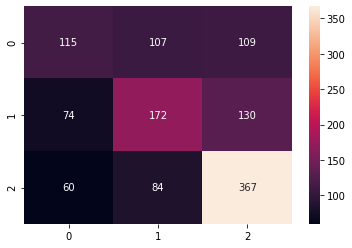

In [15]:
svm()

Fitting 10 folds for each of 256 candidates, totalling 2560 fits
RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3)
Accuracy Score ->  51.88834154351396
              precision    recall  f1-score   support

         0.0       0.52      0.11      0.18       331
         1.0       0.46      0.43      0.45       376
         2.0       0.55      0.85      0.66       511

    accuracy                           0.52      1218
   macro avg       0.51      0.46      0.43      1218
weighted avg       0.51      0.52      0.46      1218

Mean cv accuracy:  0.4895987723632008
Mean cv f1_macro:  0.40405487961134323


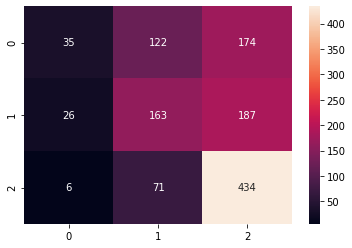

In [16]:
random_forest()

Fitting 10 folds for each of 48 candidates, totalling 480 fits
MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 100, 50))
Accuracy Score ->  46.71592775041051
              precision    recall  f1-score   support

         0.0       0.35      0.37      0.36       331
         1.0       0.42      0.34      0.37       376
         2.0       0.56      0.63      0.59       511

    accuracy                           0.47      1218
   macro avg       0.44      0.44      0.44      1218
weighted avg       0.46      0.47      0.46      1218

Mean cv accuracy:  0.4674257055168801
Mean cv f1_macro:  0.4595444254652768


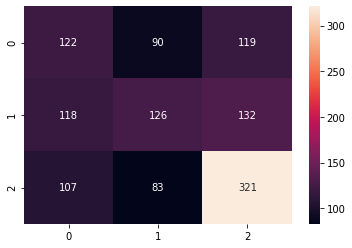

In [17]:
mlp()